In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_excel("../data/underlying_assets.xlsx", engine="openpyxl")
df.head()

,Name,Date,Close
0,삼성전자,2016-06-01,26660
1,삼성전자,2016-06-02,27300
2,삼성전자,2016-06-03,27540
3,삼성전자,2016-06-07,27960
4,삼성전자,2016-06-08,28120


<AxesSubplot:title={'center':'Histogram of the profit rate'}>

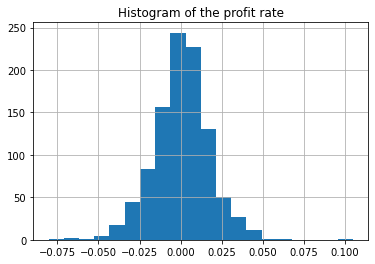

In [2]:
samsung = df[df.Name == "삼성전자"].set_index("Date").loc[:, "Close"].pct_change()

plt.title("Histogram of the profit rate")
samsung.hist(bins=20)

In [3]:
import math
import numpy as np

riskfree_rate = 0.015

s_vol = samsung[:"2017-06-29"].std() * math.sqrt(252)

samsung_s0 = df[df.Name == "삼성전자"].set_index("Date").loc["2017-06-30", "Close"]

In [4]:
import math
from tqdm import tqdm

def generate_episode(s0, vol, riskfree_rate, simulation_duration=252, delta_t=1/252):
    episode = []
    price = s0
    
    for i in range(simulation_duration):
        random_coef = np.exp((riskfree_rate - 0.5 * vol ** 2) * delta_t + vol * np.random.normal(0, 1, 1)[0] * np.sqrt(delta_t))
        price = price * random_coef
        episode.append(price)
    
    return np.round(np.array(episode))


n_simulation = 1000
episodes = []

for i in tqdm(range(n_simulation)):
    episode = generate_episode(samsung_s0, s_vol, riskfree_rate, simulation_duration=780)
    episodes.append(episode)

100%|██████████████████████████████████████| 1000/1000 [00:02<00:00, 412.32it/s]


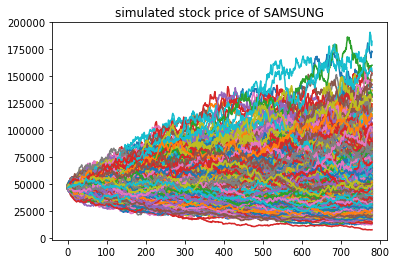

In [5]:
import matplotlib.pyplot as plt

for episode in episodes:
    plt.plot(episode)

plt.title("simulated stock price of SAMSUNG")
plt.show()

In [6]:
from datetime import date

date_0 = pd.to_datetime("2017/06/30", format = "%Y/%m/%d").date()
date_1 = pd.to_datetime("2017/12/21", format = "%Y/%m/%d").date()
date_2 = pd.to_datetime("2018/06/26", format = "%Y/%m/%d").date()
date_3 = pd.to_datetime("2018/12/20", format = "%Y/%m/%d").date()
date_4 = pd.to_datetime("2019/06/25", format = "%Y/%m/%d").date()
date_5 = pd.to_datetime("2019/12/19", format = "%Y/%m/%d").date()
date_6 = pd.to_datetime("2020/06/25", format = "%Y/%m/%d").date()

checking_date = []
for date in [date_1, date_2, date_3, date_4, date_5, date_6]:
    checking_date.append(np.busday_count(date_0, date))

checking_date = np.array(checking_date)
checking_date

array([124, 257, 384, 517, 644, 779])

In [7]:
investment_amount = 100000000

strike_price = np.round(np.array([0.87, 0.87, 0.87, 0.85, 0.85, 0.85]) * samsung_s0)
coupon_rate = np.array([0.0475, 0.095, 0.1425, 0.19, 0.2375, 0.285])
knock_in_barrier = 0.55 * samsung_s0

In [8]:
success_event = np.array([0, 0, 0, 0, 0, 0, 0])
failure_event = np.array([0])

discounted_pay_off = 0

for episode in tqdm(episodes):
    for i in range(len(strike_price)):
        if episode[checking_date][i] >= strike_price[i]:
            success_event[i] += 1
            discounted_pay_off += (investment_amount * coupon_rate[i]) * np.exp(-riskfree_rate * checking_date[i] / 252)
            break

        if np.min(episode) > knock_in_barrier:
            success_event[-1] += 1
            discounted_pay_off += (investment_amount * coupon_rate[-1]) * np.exp(-riskfree_rate * checking_date[-1] / 252)
        else:
            failure_event += 1
            discounted_pay_off += (investment_amount * episode[-1]/samsung_s0) * np.exp(-riskfree_rate * checking_date[-1] / 252)

npv = int(discounted_pay_off / len(episodes))
success_df = pd.DataFrame({"Condition": ["cond_01", "cond_02", "cond_03", "cond_04", "cond_05", "cond_06", "cond_07"],
                           "# Events": success_event})
failure_df = pd.DataFrame({"Condition": ["cond_08"],
                           "# Events": failure_event})

print(f"valuation: {npv}\n\nsuccess events\n{success_df}\n\nfailure events\n{failure_df}")

100%|████████████████████████████████████| 1000/1000 [00:00<00:00, 53598.59it/s]

valuation: 46740138

success events
  Condition  # Events
0   cond_01       768
1   cond_02        64
2   cond_03        20
3   cond_04        15
4   cond_05        14
5   cond_06        11
6   cond_07       303

failure events
  Condition  # Events
0   cond_08       605
